#### EDA - Text Classification - Ham vs Spam Filter

In [52]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import re
from wordcloud import WordCloud
from scipy import stats

# Plotting Style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [13]:
df = pd.read_csv('../data/raw/spam.csv', encoding='latin-1')
print(f"\nDataset shape: {df.shape}")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print("\nFirst 5 rows of the dataset:")
print(df.head())
print('\n Last 5 rows of the dataset:')
print(df.tail())


Dataset shape: (5572, 5)
Number of rows: 5572
Number of columns: 5

First 5 rows of the dataset:
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  

 Last 5 rows of the dataset:
        v1                                                 v2 Unnamed: 2  \
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham              Will Ì_ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...an

In [15]:
# Column Info

print("\nColumn Information:")
print(df.columns.to_list())

print("\nDatatype Info:")
print(df.dtypes)

print("\n Dataset Info:")
print(df.info())


Column Information:
['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']

Datatype Info:
v1            object
v2            object
Unnamed: 2    object
Unnamed: 3    object
Unnamed: 4    object
dtype: object

 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None



Missing values by column:
       Column  Missing_Count  Missing_Percent
0          v1              0         0.000000
1          v2              0         0.000000
2  Unnamed: 2           5522        99.102656
3  Unnamed: 3           5560        99.784637
4  Unnamed: 4           5566        99.892319


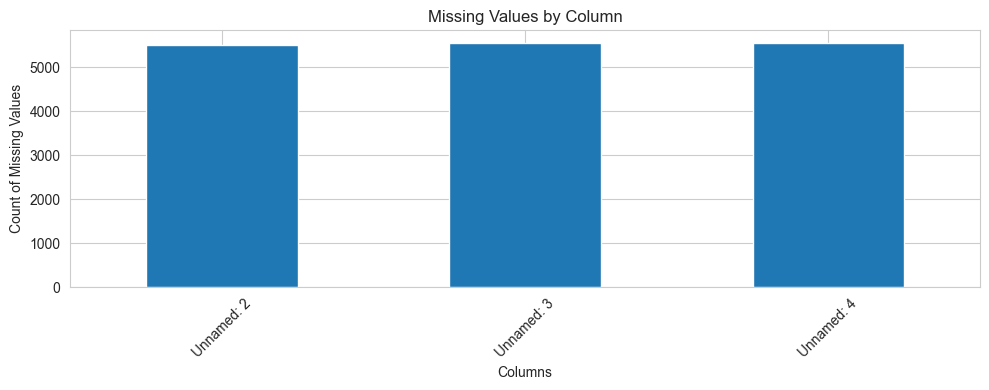

In [16]:
# Missing Values

missing = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing_Count': missing.values,
    'Missing_Percent': missing_percent.values
})

print("\nMissing values by column:")
print(missing_df)

# Visualize missing values
if missing.sum() > 0:
    plt.figure(figsize=(10, 4))
    missing[missing > 0].plot(kind='bar')
    plt.title('Missing Values by Column')
    plt.xlabel('Columns')
    plt.ylabel('Count of Missing Values')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("\n✓ No missing values found!")

In [17]:
# Renaming columns

if 'v1' in df.columns and 'v2' in df.columns:
    # Keep only the first two columns
    df = df[['v1', 'v2']]
    df.columns = ['label', 'message']
    print("\n✓ Columns renamed to 'label' and 'message'")
else:
    print("\n⚠ Column names don't match expected format. Current columns:")
    print(df.columns.tolist())

print("\nCleaned dataset:")
print(df.head())


✓ Columns renamed to 'label' and 'message'

Cleaned dataset:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...



Class counts:
label
ham     4825
spam     747
Name: count, dtype: int64

Class percentages:
label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64

Summary:
       Count  Percentage
label                   
ham     4825   86.593683
spam     747   13.406317


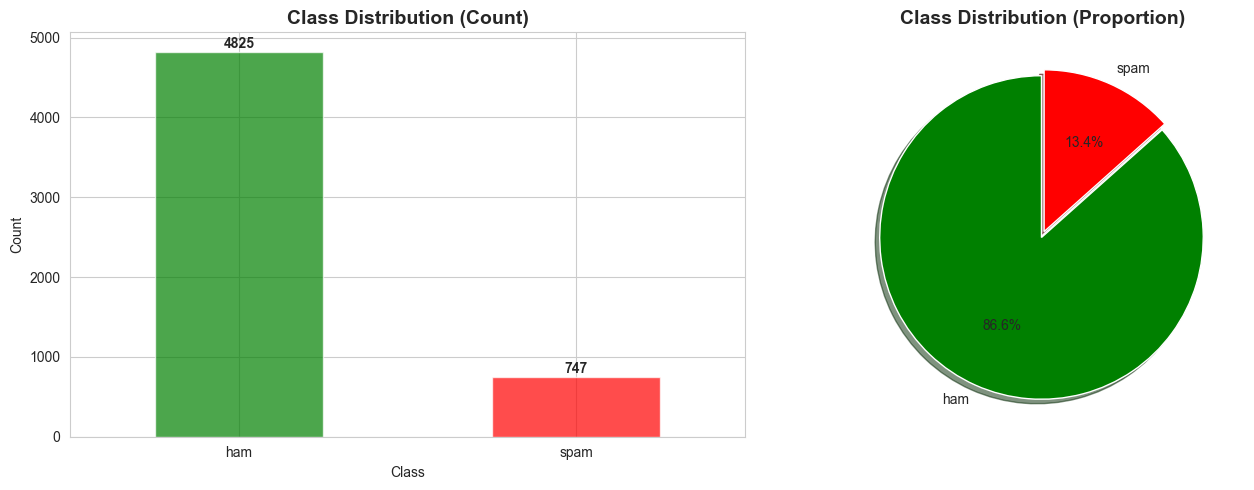

Class Imbalance Ratio: 6.46:1
Dataset is imbalanced - Need to consider this when training models


In [27]:
# Class Distribution

class_counts = df['label'].value_counts()
print("\nClass counts:")
print(class_counts)

# Percentage by class
class_percent = df['label'].value_counts(normalize=True) * 100
print("\nClass percentages:")
print(class_percent)

# Create summary table
summary = pd.DataFrame({
    'Count': class_counts,
    'Percentage': class_percent
})
print("\nSummary:")
print(summary)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
class_counts.plot(kind='bar', ax=axes[0], color=['green', 'red'], alpha=0.7)
axes[0].set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Add value labels on bars
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Pie chart
colors = ['green', 'red']
explode = (0.02, 0.02)
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            colors=colors, explode=explode, shadow=True, startangle=90)
axes[1].set_title('Class Distribution (Proportion)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Checking for class imbalance
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"Class Imbalance Ratio: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 2:
    print("Dataset is imbalanced - Need to consider this when training models")
else:
    print("Dataset is relatively balanced")

In [29]:
# Sample Message inspection from each class

print("\nSample ham message:")
ham_samples = df[df['label'] == 'ham']['message'].sample(3, random_state=42)
for i, msg in enumerate(ham_samples, 1):
    print(f"\n{i}. {msg}")

print("\nSample spam message:")
spam_samples = df[df['label'] == 'spam']['message'].sample(3, random_state=42)
for i, msg in enumerate(spam_samples, 1):
    print(f"\n{i}. {msg}")



Sample ham message:

1. I am late,so call you tomorrow morning.take care sweet dreams....u and me...ummifying...bye.

2. U r too much close to my heart. If u go away i will be shattered. Plz stay with me.

3. Wait  &lt;#&gt;  min..

Sample spam message:

1. Summers finally here! Fancy a chat or flirt with sexy singles in yr area? To get MATCHED up just reply SUMMER now. Free 2 Join. OptOut txt STOP Help08714742804

2. This is the 2nd time we have tried 2 contact u. U have won the 750 Pound prize. 2 claim is easy, call 08718726970 NOW! Only 10p per min. BT-national-rate 

3. Get ur 1st RINGTONE FREE NOW! Reply to this msg with TONE. Gr8 TOP 20 tones to your phone every week just å£1.50 per wk 2 opt out send STOP 08452810071 16



Overall message length statistics:
count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: message_length, dtype: float64

Message length by class:
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0
spam    747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0


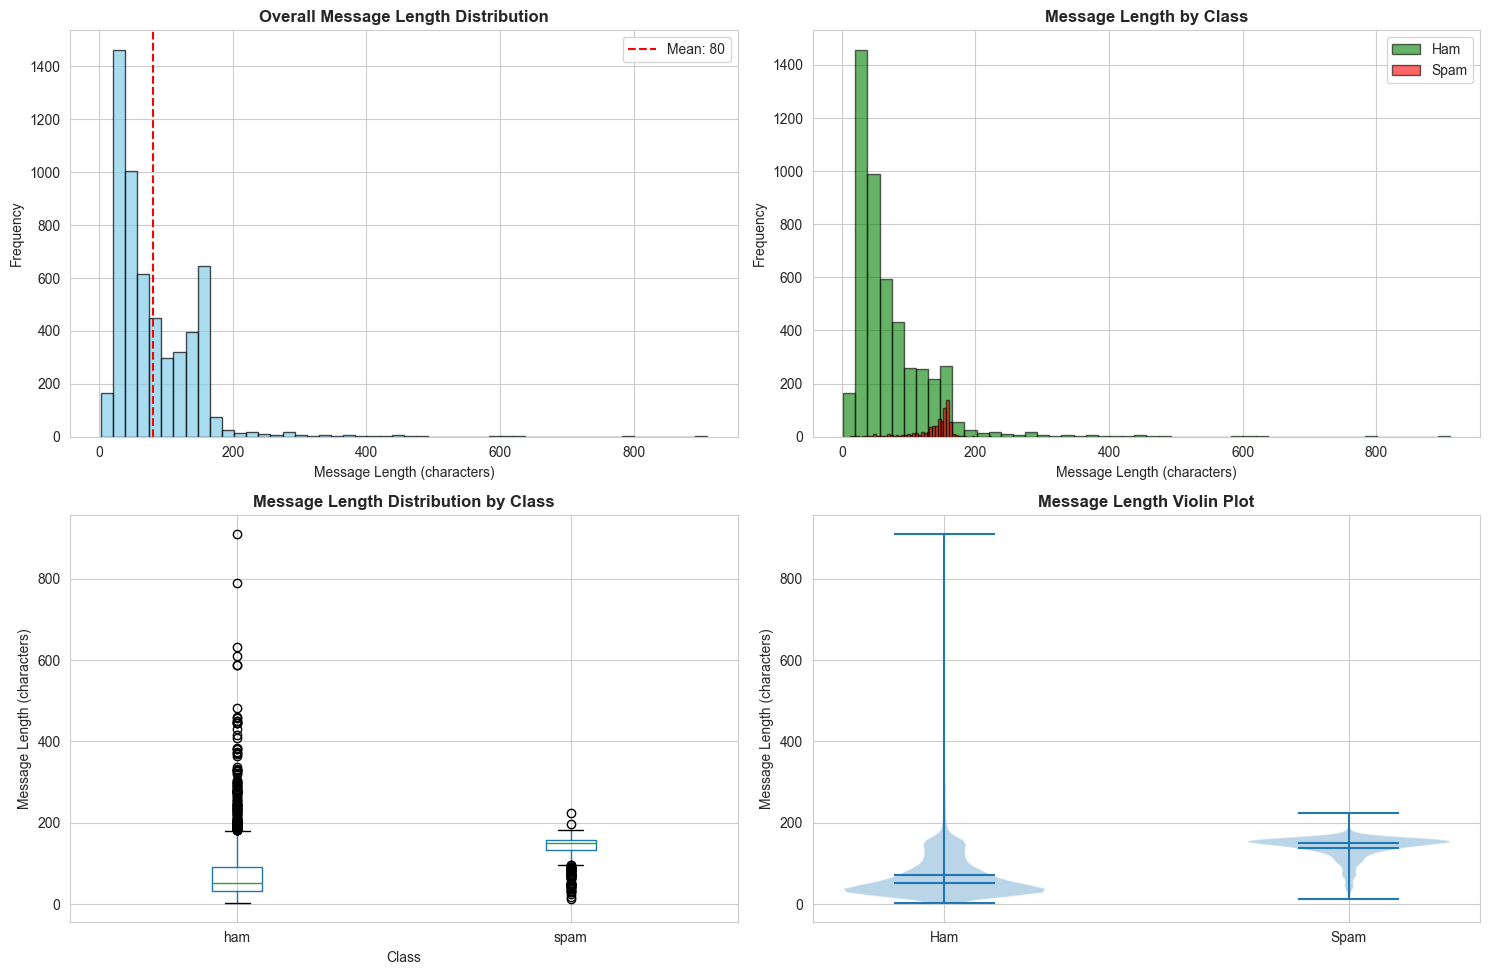


Statistical comparison:
Average Ham message length: 71.02 characters
Average Spam message length: 138.87 characters
Difference: 67.84 characters


In [31]:
# Message Length Analysis

df['message_length'] = df['message'].apply(len)

print("\nOverall message length statistics:")
print(df['message_length'].describe())

print("\nMessage length by class:")
print(df.groupby('label')['message_length'].describe())


fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Overall distribution
axes[0, 0].hist(df['message_length'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Overall Message Length Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Message Length (characters)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['message_length'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {df["message_length"].mean():.0f}')
axes[0, 0].legend()

# Distribution by class
ham_length = df[df['label'] == 'ham']['message_length']
spam_length = df[df['label'] == 'spam']['message_length']

axes[0, 1].hist(ham_length, bins=50, alpha=0.6, label='Ham', color='green', edgecolor='black')
axes[0, 1].hist(spam_length, bins=50, alpha=0.6, label='Spam', color='red', edgecolor='black')
axes[0, 1].set_title('Message Length by Class', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Message Length (characters)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Box plot by class
df.boxplot(column='message_length', by='label', ax=axes[1, 0])
axes[1, 0].set_title('Message Length Distribution by Class', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Class')
axes[1, 0].set_ylabel('Message Length (characters)')
plt.suptitle('')  # Remove automatic title

# Violin plot
spam_data = df[df['label'] == 'spam']['message_length']
ham_data = df[df['label'] == 'ham']['message_length']
axes[1, 1].violinplot([ham_data, spam_data], positions=[1, 2], showmeans=True, showmedians=True)
axes[1, 1].set_title('Message Length Violin Plot', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks([1, 2])
axes[1, 1].set_xticklabels(['Ham', 'Spam'])
axes[1, 1].set_ylabel('Message Length (characters)')

plt.tight_layout()
plt.show()

# Statistical comparison
print("\nStatistical comparison:")
print(f"Average Ham message length: {ham_length.mean():.2f} characters")
print(f"Average Spam message length: {spam_length.mean():.2f} characters")
print(f"Difference: {abs(ham_length.mean() - spam_length.mean()):.2f} characters")


Overall word count statistics:
count    5572.000000
mean       15.494436
std        11.329427
min         1.000000
25%         7.000000
50%        12.000000
75%        23.000000
max       171.000000
Name: word_count, dtype: float64

Word count by class:
        count       mean        std  min   25%   50%   75%    max
label                                                            
ham    4825.0  14.200622  11.424511  1.0   7.0  11.0  19.0  171.0
spam    747.0  23.851406   5.811898  2.0  22.0  25.0  28.0   35.0


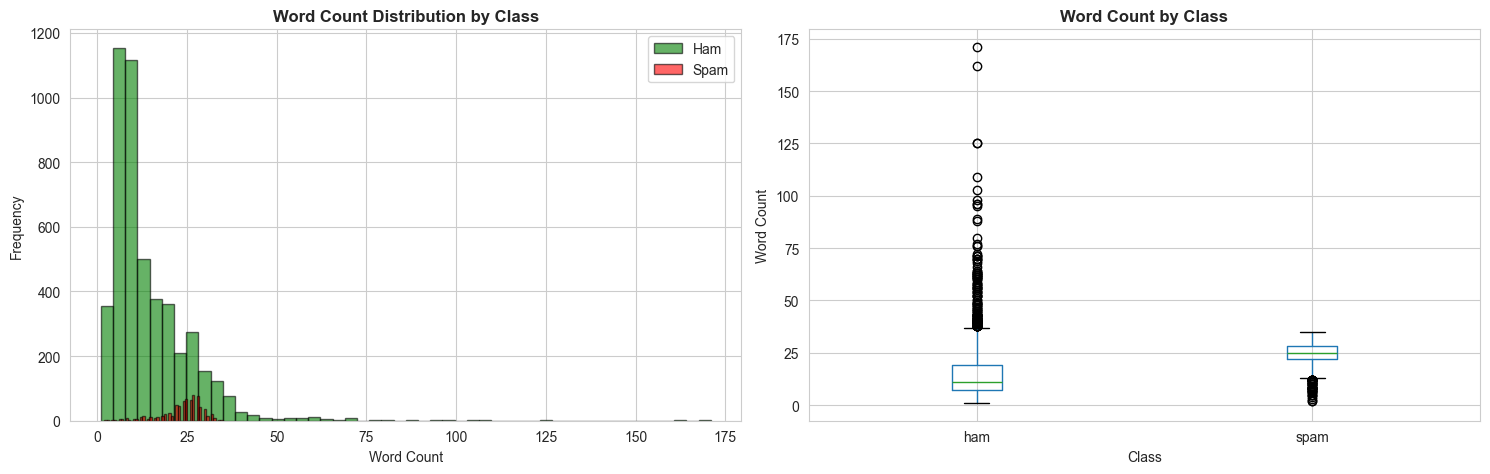


Average Ham word count: 14.20 words
Average Spam word count: 23.85 words


In [32]:
# Word Count

df['word_count'] = df['message'].apply(lambda x: len(str(x).split()))

print("\nOverall word count statistics:")
print(df['word_count'].describe())

print("\nWord count by class:")
print(df.groupby('label')['word_count'].describe())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution by class
ham_words = df[df['label'] == 'ham']['word_count']
spam_words = df[df['label'] == 'spam']['word_count']

axes[0].hist(ham_words, bins=50, alpha=0.6, label='Ham', color='green', edgecolor='black')
axes[0].hist(spam_words, bins=50, alpha=0.6, label='Spam', color='red', edgecolor='black')
axes[0].set_title('Word Count Distribution by Class', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Box plot
df.boxplot(column='word_count', by='label', ax=axes[1])
axes[1].set_title('Word Count by Class', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Word Count')
plt.suptitle('')

plt.tight_layout()
plt.show()

print(f"\nAverage Ham word count: {ham_words.mean():.2f} words")
print(f"Average Spam word count: {spam_words.mean():.2f} words")


Average word length by class:
        count      mean       std       min       25%       50%    75%  \
label                                                                    
ham    4825.0  4.177574  1.133530  1.500000  3.600000  4.000000  4.500   
spam    747.0  4.992839  1.005943  3.333333  4.423077  4.884615  5.375   

             max  
label             
ham    49.000000  
spam   17.333333  


<Figure size 1000x600 with 0 Axes>

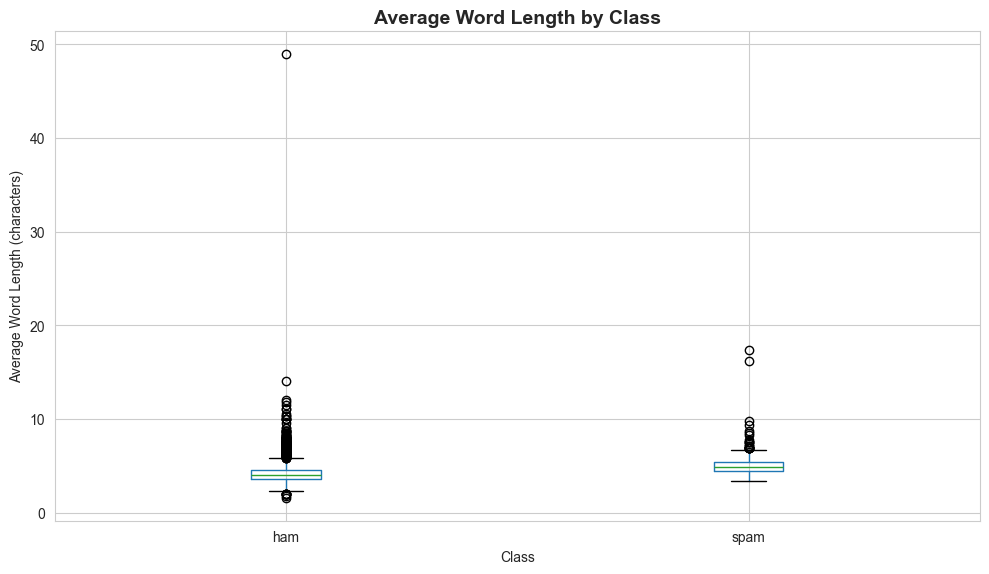

In [33]:
# Average word length

df['avg_word_length'] = df['message'].apply(
    lambda x: np.mean([len(word) for word in str(x).split()]) if len(str(x).split()) > 0 else 0
)

print("\nAverage word length by class:")
print(df.groupby('label')['avg_word_length'].describe())

# Visualize
plt.figure(figsize=(10, 6))
df.boxplot(column='avg_word_length', by='label')
plt.title('Average Word Length by Class', fontsize=14, fontweight='bold')
plt.suptitle('')
plt.xlabel('Class')
plt.ylabel('Average Word Length (characters)')
plt.tight_layout()
plt.show()

In [36]:
# Common Words

def get_common_words(messages, n=20):
    words = []
    for msg in messages:
        words.extend(str(msg).lower().split())
    return Counter(words).most_common(n)

# Overall most common words
print("\nTop 20 most common words (overall):")
all_common = get_common_words(df['message'])
for word, count in all_common:
    print(f"{word:15} : {count:5} times")

print("\n")
print("\nTop 20 most common words in HAM messages:")
ham_common = get_common_words(df[df['label'] == 'ham']['message'])
for word, count in ham_common:
    print(f"{word:15} : {count:5} times")

print("\n")
print("\nTop 20 most common words in SPAM messages:")

spam_common = get_common_words(df[df['label'] == 'spam']['message'])
for word, count in spam_common:
    print(f"{word:15} : {count:5} times")


Top 20 most common words (overall):
to              :  2226 times
i               :  2208 times
you             :  1917 times
a               :  1419 times
the             :  1317 times
u               :   991 times
and             :   967 times
is              :   862 times
in              :   855 times
my              :   751 times
for             :   697 times
your            :   676 times
of              :   613 times
me              :   605 times
have            :   568 times
call            :   557 times
on              :   520 times
are             :   485 times
that            :   468 times
it              :   465 times



Top 20 most common words in HAM messages:
i               :  2172 times
you             :  1665 times
to              :  1544 times
the             :  1113 times
a               :  1046 times
u               :   874 times
and             :   845 times
in              :   786 times
my              :   741 times
is              :   710 times
me              : 


Exclamation marks by class:
        count      mean       std  min  25%  50%  75%   max
label                                                      
ham    4825.0  0.173886  0.598698  0.0  0.0  0.0  0.0  11.0
spam    747.0  0.725569  0.939698  0.0  0.0  0.0  1.0   5.0

Question marks by class:
        count      mean       std  min  25%  50%  75%   max
label                                                      
ham    4825.0  0.283316  0.651524  0.0  0.0  0.0  0.0  12.0
spam    747.0  0.232932  0.582900  0.0  0.0  0.0  0.0   4.0

Capital letter ratio by class:
        count      mean       std  min       25%       50%       75%       max
label                                                                         
ham    4825.0  0.059526  0.110807  0.0  0.025000  0.035714  0.051282  1.000000
spam    747.0  0.110612  0.084961  0.0  0.056604  0.098592  0.142857  0.785276


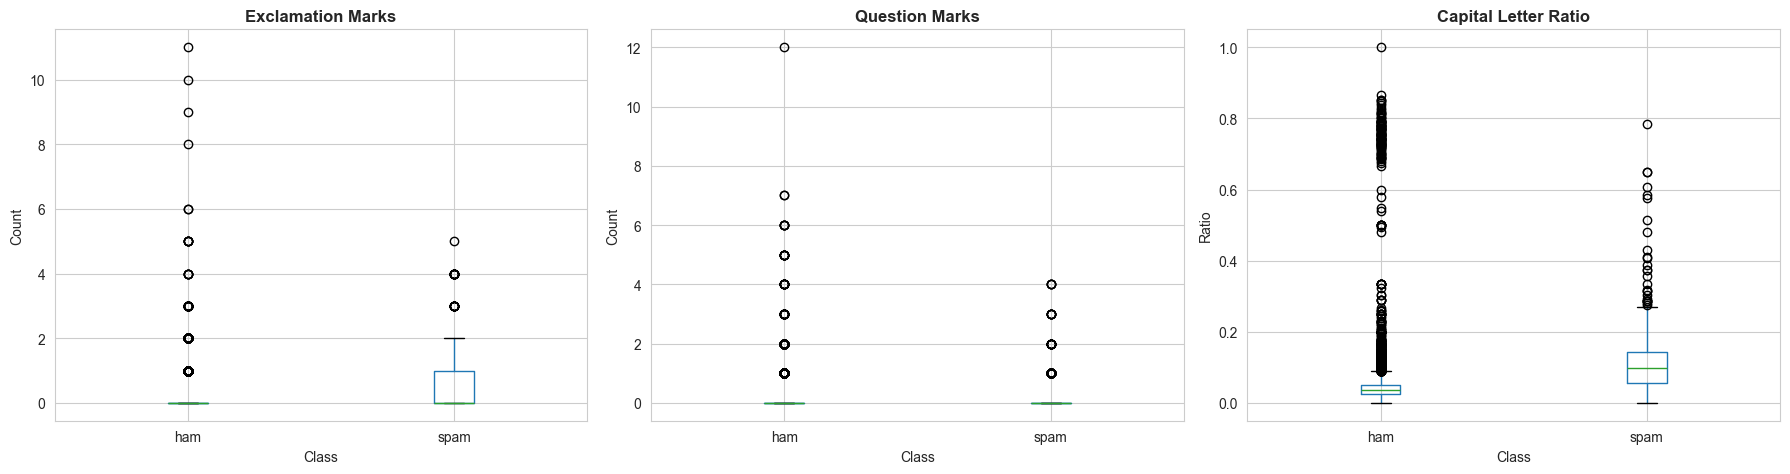

In [37]:
# Analyzing characters

df['num_exclamation'] = df['message'].apply(lambda x: x.count('!'))
df['num_question'] = df['message'].apply(lambda x: x.count('?'))
df['num_capitals'] = df['message'].apply(lambda x: sum(1 for c in x if c.isupper()))
df['capital_ratio'] = df['num_capitals'] / df['message_length']

print("\nExclamation marks by class:")
print(df.groupby('label')['num_exclamation'].describe())

print("\nQuestion marks by class:")
print(df.groupby('label')['num_question'].describe())

print("\nCapital letter ratio by class:")
print(df.groupby('label')['capital_ratio'].describe())

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

df.boxplot(column='num_exclamation', by='label', ax=axes[0])
axes[0].set_title('Exclamation Marks', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

df.boxplot(column='num_question', by='label', ax=axes[1])
axes[1].set_title('Question Marks', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

df.boxplot(column='capital_ratio', by='label', ax=axes[2])
axes[2].set_title('Capital Letter Ratio', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('Ratio')

plt.suptitle('')
plt.tight_layout()
plt.show()


In [38]:
# Summary Stats

summary_stats = df.groupby('label').agg({
    'message_length': ['mean', 'median', 'std'],
    'word_count': ['mean', 'median', 'std'],
    'avg_word_length': ['mean', 'median'],
    'num_exclamation': ['mean', 'sum'],
    'num_question': ['mean', 'sum'],
    'capital_ratio': ['mean', 'median']
}).round(2)

print("\n", summary_stats)


       message_length               word_count               avg_word_length  \
                mean median    std       mean median    std            mean   
label                                                                         
ham            71.02   52.0  58.02      14.20   11.0  11.42            4.18   
spam          138.87  149.0  29.18      23.85   25.0   5.81            4.99   

             num_exclamation      num_question       capital_ratio         
      median            mean  sum         mean   sum          mean median  
label                                                                      
ham     4.00            0.17  839         0.28  1367          0.06   0.04  
spam    4.88            0.73  542         0.23   174          0.11   0.10  


In [41]:
# Findings

print(f"""
1. DATASET SIZE:
   - Total messages: {len(df):,}
   - Ham messages: {len(df[df['label']=='ham']):,} ({len(df[df['label']=='ham'])/len(df)*100:.1f}%)
   - Spam messages: {len(df[df['label']=='spam']):,} ({len(df[df['label']=='spam'])/len(df)*100:.1f}%)
   - Class imbalance ratio: {imbalance_ratio:.2f}:1

2. MESSAGE LENGTH:
   - Average Ham: {ham_length.mean():.0f} characters
   - Average Spam: {spam_length.mean():.0f} characters
   - Spam messages are {'longer' if spam_length.mean() > ham_length.mean() else 'shorter'} on average

3. WORD COUNT:
   - Average Ham: {ham_words.mean():.1f} words
   - Average Spam: {spam_words.mean():.1f} words

4. SPECIAL CHARACTERS:
   - Spam uses more exclamation marks: {df[df['label']=='spam']['num_exclamation'].mean():.2f} vs {df[df['label']=='ham']['num_exclamation'].mean():.2f}
   - Capital letter usage differs between classes
""")


1. DATASET SIZE:
   - Total messages: 5,572
   - Ham messages: 4,825 (86.6%)
   - Spam messages: 747 (13.4%)
   - Class imbalance ratio: 6.46:1

2. MESSAGE LENGTH:
   - Average Ham: 71 characters
   - Average Spam: 139 characters
   - Spam messages are longer on average

3. WORD COUNT:
   - Average Ham: 14.2 words
   - Average Spam: 23.9 words

4. SPECIAL CHARACTERS:
   - Spam uses more exclamation marks: 0.73 vs 0.17
   - Capital letter usage differs between classes




Percentage of messages with numbers:
label  has_numbers
ham    False          84.497409
       True           15.502591
spam   True           94.779116
       False           5.220884
Name: proportion, dtype: float64

Percentage of messages with currency symbols:
label  has_currency
ham    False           99.626943
       True             0.373057
spam   False           65.595716
       True            34.404284
Name: proportion, dtype: float64

Percentage of messages with phone numbers:
label  has_phone
ham    False        99.979275
       True          0.020725
spam   True         57.295850
       False        42.704150
Name: proportion, dtype: float64

Percentage of messages with URLs:
label  has_url
ham    False      99.958549
       True        0.041451
spam   False      86.077644
       True       13.922356
Name: proportion, dtype: float64


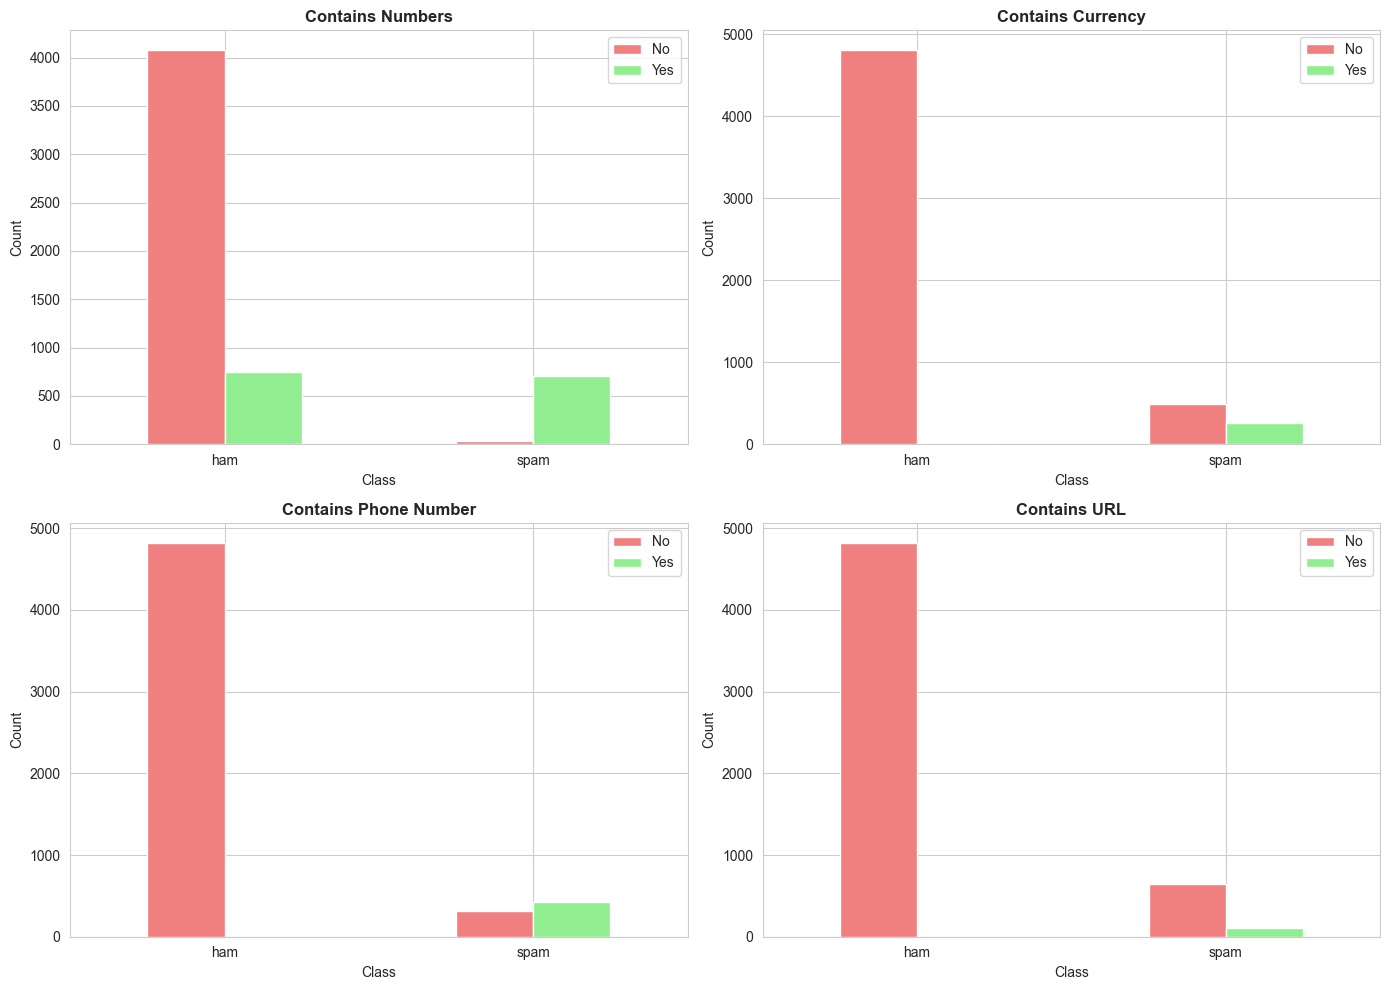

In [43]:
# Currency in messages

# Detect patterns
df['has_numbers'] = df['message'].apply(lambda x: bool(re.search(r'\d', x)))
df['has_currency'] = df['message'].apply(lambda x: bool(re.search(r'[$£€¥₹]', x)))
df['has_phone'] = df['message'].apply(lambda x: bool(re.search(r'\d{10}|\d{3}[-.\s]?\d{3}[-.\s]?\d{4}', x)))
df['has_url'] = df['message'].apply(lambda x: bool(re.search(r'http[s]?://|www\.', x)))

print("\nPercentage of messages with numbers:")
print(df.groupby('label')['has_numbers'].value_counts(normalize=True) * 100)

print("\nPercentage of messages with currency symbols:")
print(df.groupby('label')['has_currency'].value_counts(normalize=True) * 100)

print("\nPercentage of messages with phone numbers:")
print(df.groupby('label')['has_phone'].value_counts(normalize=True) * 100)

print("\nPercentage of messages with URLs:")
print(df.groupby('label')['has_url'].value_counts(normalize=True) * 100)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, (col, title) in enumerate([
    ('has_numbers', 'Contains Numbers'),
    ('has_currency', 'Contains Currency'),
    ('has_phone', 'Contains Phone Number'),
    ('has_url', 'Contains URL')
]):
    ax = axes[idx // 2, idx % 2]
    
    data = df.groupby(['label', col]).size().unstack(fill_value=0)
    data.plot(kind='bar', ax=ax, color=['lightcoral', 'lightgreen'])
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.legend(['No', 'Yes'])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()



Urgency words by class:
        count      mean       std  min  25%  50%  75%  max
label                                                     
ham    4825.0  0.143627  0.356609  0.0  0.0  0.0  0.0  2.0
spam    747.0  0.465863  0.603697  0.0  0.0  0.0  1.0  2.0

Money words by class:
        count      mean       std  min  25%  50%  75%  max
label                                                     
ham    4825.0  0.041451  0.204484  0.0  0.0  0.0  0.0  2.0
spam    747.0  0.842035  0.940139  0.0  0.0  1.0  1.0  5.0

Action words by class:
        count      mean       std  min  25%  50%  75%  max
label                                                     
ham    4825.0  0.132021  0.361641  0.0  0.0  0.0  0.0  3.0
spam    747.0  0.965194  0.763700  0.0  1.0  1.0  1.0  4.0


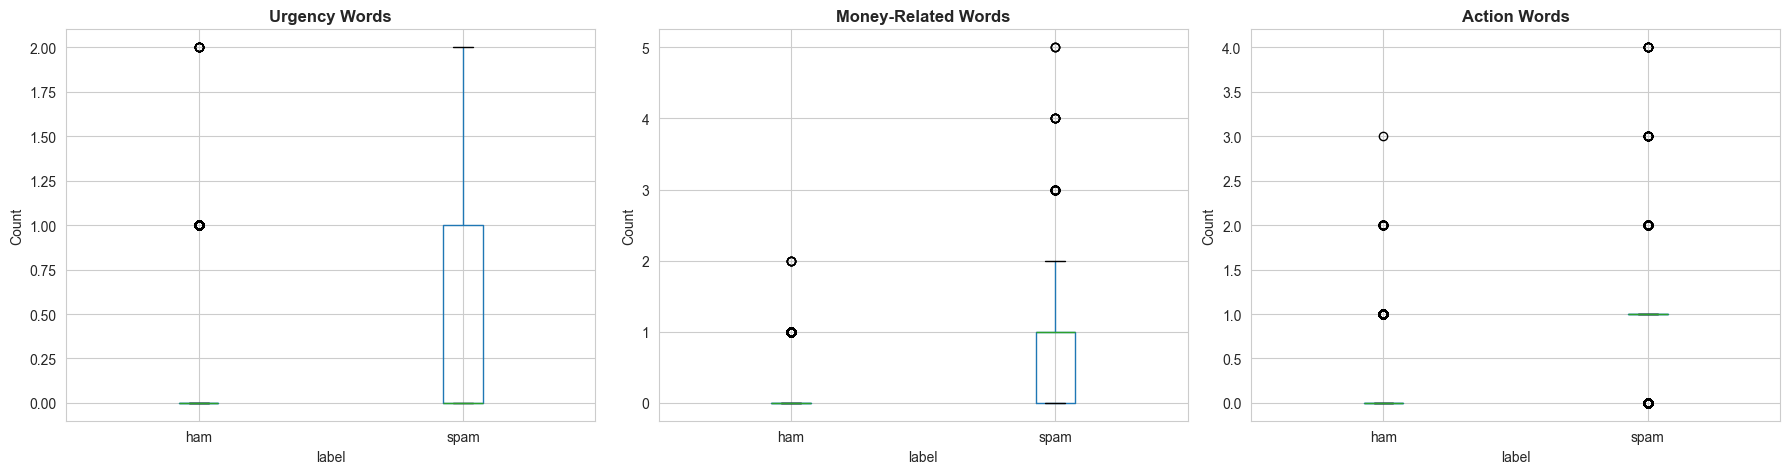

In [44]:
# Urgency Analysis
# Define spam trigger words
urgency_words = ['urgent', 'now', 'immediately', 'asap', 'hurry', 'limited', 'expire', 'today']
money_words = ['free', 'win', 'winner', 'cash', 'prize', 'bonus', 'claim', 'reward', 'money']
action_words = ['call', 'click', 'buy', 'order', 'subscribe', 'text', 'reply', 'send']

def count_trigger_words(text, word_list):
    text_lower = text.lower()
    return sum(1 for word in word_list if word in text_lower)

df['urgency_count'] = df['message'].apply(lambda x: count_trigger_words(x, urgency_words))
df['money_count'] = df['message'].apply(lambda x: count_trigger_words(x, money_words))
df['action_count'] = df['message'].apply(lambda x: count_trigger_words(x, action_words))

print("\nUrgency words by class:")
print(df.groupby('label')['urgency_count'].describe())

print("\nMoney words by class:")
print(df.groupby('label')['money_count'].describe())

print("\nAction words by class:")
print(df.groupby('label')['action_count'].describe())

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

df.boxplot(column='urgency_count', by='label', ax=axes[0])
axes[0].set_title('Urgency Words', fontweight='bold')
axes[0].set_ylabel('Count')

df.boxplot(column='money_count', by='label', ax=axes[1])
axes[1].set_title('Money-Related Words', fontweight='bold')
axes[1].set_ylabel('Count')

df.boxplot(column='action_count', by='label', ax=axes[2])
axes[2].set_title('Action Words', fontweight='bold')
axes[2].set_ylabel('Count')

plt.suptitle('')
plt.tight_layout()
plt.show()


In [48]:
# Time-based Analysis

time_words = ['today', 'tomorrow', 'tonight', 'now', 'week', 'month', 'day', 
              'morning', 'evening', 'later', 'soon', 'asap']

df['has_time_words'] = df['message'].apply(
    lambda x: any(word in x.lower() for word in time_words)
)

print("\nPercentage with time-related words:")
print(df.groupby('label')['has_time_words'].value_counts(normalize=True) * 100)

# ============================================================================
# CELL: Message Uniqueness
# ============================================================================

print("\n" + "="*60)
print("MESSAGE UNIQUENESS ANALYSIS")
print("="*60)

# Check for duplicate messages
duplicates = df.duplicated(subset=['message'], keep=False)
print(f"\nTotal duplicate messages: {duplicates.sum()}")

print("\nDuplicates by class:")
print(df[duplicates].groupby('label').size())

# Find most common messages
print("\nTop 10 most repeated messages:")
top_repeated = df['message'].value_counts().head(10)
for msg, count in top_repeated.items():
    label = df[df['message'] == msg]['label'].iloc[0]
    print(f"\n[{label.upper()}] (appears {count} times)")
    print(f"  {msg[:80]}...")


Percentage with time-related words:
label  has_time_words
ham    False             72.290155
       True              27.709845
spam   True              51.539491
       False             48.460509
Name: proportion, dtype: float64

MESSAGE UNIQUENESS ANALYSIS

Total duplicate messages: 684

Duplicates by class:
label
ham     503
spam    181
dtype: int64

Top 10 most repeated messages:

[HAM] (appears 30 times)
  Sorry, I'll call later...

[HAM] (appears 12 times)
  I cant pick the phone right now. Pls send a message...

[HAM] (appears 10 times)
  Ok......

[HAM] (appears 4 times)
  7 wonders in My WORLD 7th You 6th Ur style 5th Ur smile 4th Ur Personality 3rd U...

[HAM] (appears 4 times)
  Say this slowly.? GOD,I LOVE YOU &amp; I NEED YOU,CLEAN MY HEART WITH YOUR BLOOD...

[HAM] (appears 4 times)
  Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl c...

[HAM] (appears 4 times)
  Ok....

[HAM] (appears 4 times)
  Wen ur lovable bcums angry wid u, dnt take 

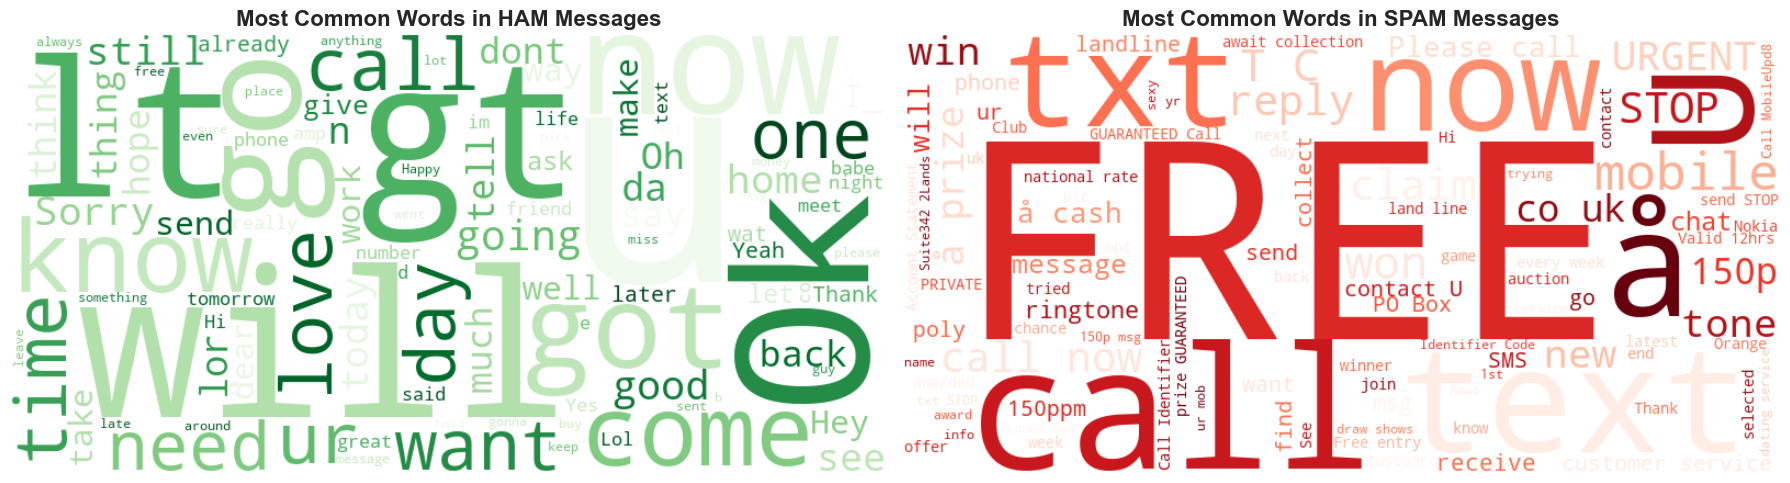

In [47]:
# Word Cloud Viz

# Combine all messages by class
ham_text = ' '.join(df[df['label'] == 'ham']['message'].astype(str))
spam_text = ' '.join(df[df['label'] == 'spam']['message'].astype(str))

# Create word clouds
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Ham word cloud
ham_wordcloud = WordCloud(width=800, height=400, 
                          background_color='white',
                          colormap='Greens',
                          max_words=100).generate(ham_text)

axes[0].imshow(ham_wordcloud, interpolation='bilinear')
axes[0].set_title('Most Common Words in HAM Messages', fontsize=16, fontweight='bold')
axes[0].axis('off')

# Spam word cloud
spam_wordcloud = WordCloud(width=800, height=400, 
                           background_color='white',
                           colormap='Reds',
                           max_words=100).generate(spam_text)

axes[1].imshow(spam_wordcloud, interpolation='bilinear')
axes[1].set_title('Most Common Words in SPAM Messages', fontsize=16, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [49]:
# Specific Spam Indicators

patterns = {
    'starts_with_free': r'^free\s',
    'congratulations': r'congratulations',
    'youve_won': r"you'?ve won|you won",
    'click_here': r'click here',
    'call_now': r'call now',
    'txt_to': r'txt to|text to',
    'reply_to': r'reply to',
}

for pattern_name, regex in patterns.items():
    df[pattern_name] = df['message'].str.lower().str.contains(regex, regex=True)
    
    spam_count = df[(df['label'] == 'spam') & df[pattern_name]].shape[0]
    ham_count = df[(df['label'] == 'ham') & df[pattern_name]].shape[0]
    
    print(f"\n{pattern_name.replace('_', ' ').title()}:")
    print(f"  Spam: {spam_count} ({spam_count/df[df['label']=='spam'].shape[0]*100:.1f}%)")
    print(f"  Ham:  {ham_count} ({ham_count/df[df['label']=='ham'].shape[0]*100:.1f}%)")



Starts With Free:
  Spam: 34 (4.6%)
  Ham:  1 (0.0%)

Congratulations:
  Spam: 14 (1.9%)
  Ham:  1 (0.0%)

Youve Won:
  Spam: 8 (1.1%)
  Ham:  6 (0.1%)

Click Here:
  Spam: 1 (0.1%)
  Ham:  0 (0.0%)

Call Now:
  Spam: 19 (2.5%)
  Ham:  3 (0.1%)

Txt To:
  Spam: 9 (1.2%)
  Ham:  1 (0.0%)

Reply To:
  Spam: 13 (1.7%)
  Ham:  7 (0.1%)


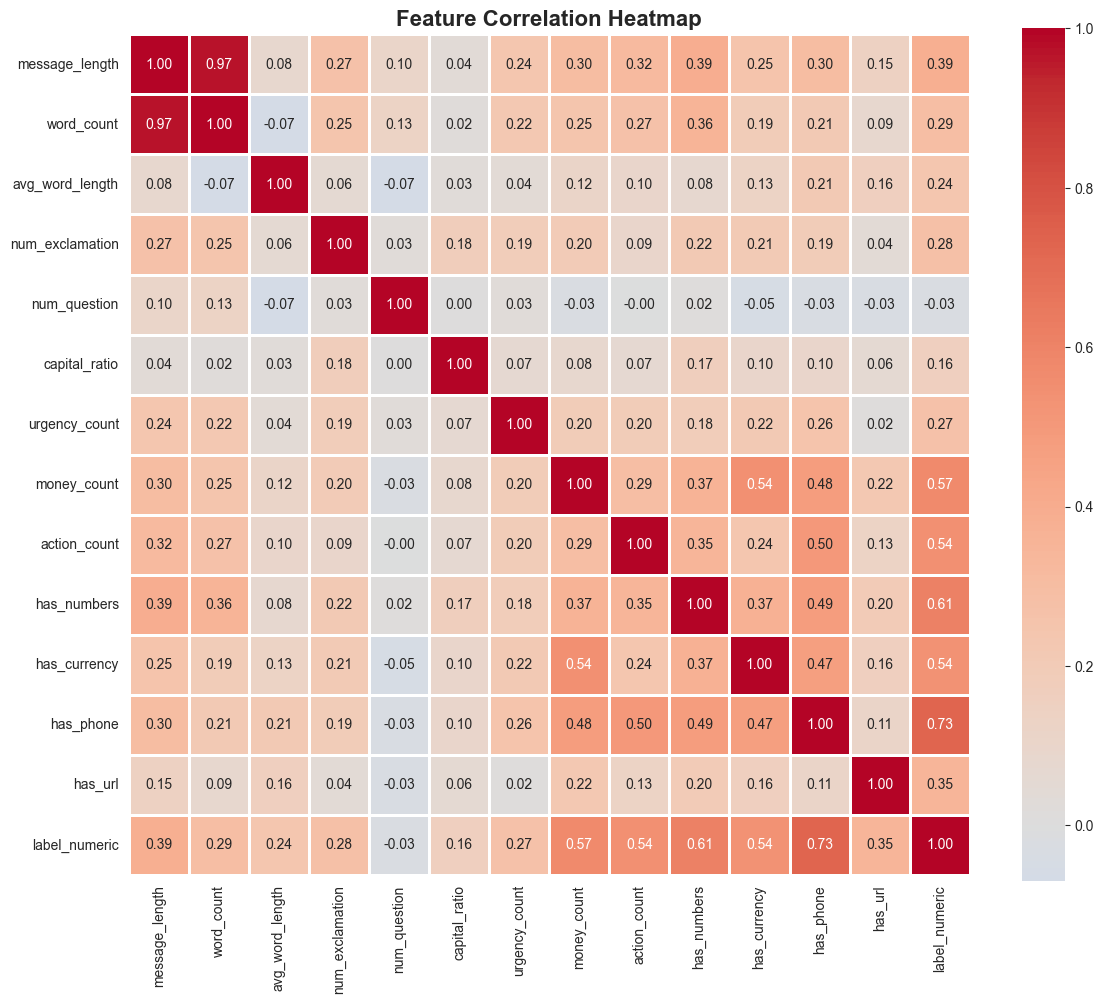


Features most correlated with spam (label):
label_numeric      1.000000
has_phone          0.732046
has_numbers        0.614802
money_count        0.570089
action_count       0.544413
has_currency       0.535310
message_length     0.387285
has_url            0.346210
word_count         0.290263
num_exclamation    0.275985
urgency_count      0.265548
avg_word_length    0.241314
capital_ratio      0.159567
num_question      -0.026704
Name: label_numeric, dtype: float64


In [50]:
# Feature Heatmap

# Select numerical features
feature_cols = ['message_length', 'word_count', 'avg_word_length', 
                'num_exclamation', 'num_question', 'capital_ratio',
                'urgency_count', 'money_count', 'action_count',
                'has_numbers', 'has_currency', 'has_phone', 'has_url']

# Convert label to numeric for correlation
df['label_numeric'] = df['label'].map({'ham': 0, 'spam': 1})

# Calculate correlation
correlation_data = df[feature_cols + ['label_numeric']].astype(float)
correlation_matrix = correlation_data.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Features most correlated with spam
print("\nFeatures most correlated with spam (label):")
spam_correlations = correlation_matrix['label_numeric'].sort_values(ascending=False)
print(spam_correlations)

##### Based on the Heatmap

1. **has_phone**: Very strong.
    - Message with Phone # are **Highly Likely** to be spam
    - 73.2% of the variation can be explained by phone # presence. 
    - Must have feature in the model. 
2. **has_numbers**: Strong.
    - Messages with any numbers - dates, amounts, codes, lean towards spam. Strong but weaker than phone number. Exception: Personal message like meet me at 11 AM etc (but less commmon)
    - Personal messages less likely to have numbers. 
3. **money_count**: Strong
    - More money-related words - Free, win, prize, cash, bonus - Likely spam
4. **action_count**: Strong
    - more call to action words, more likely spam. 
    - Spammer mostly want us to do something immediately. 
5. **has_currency**: Strong
    - Similar to money but more specific
    - Personal messages rarely use currency symbols. 

##### Features - I'm considering

Tier 1: Must-Have Features (Very Strong)

1. has_phone (0.73)
2. has_numbers (0.61)

Tier 2: Strong Features

3. money_count (0.57)
4. action_count (0.54)
5. has_currency (0.54)

Tier 3: Moderate Features

6. message_length (0.39) - Useful but not critical
7. has_url (0.35) - Useful but not critical
8. word_count (0.29) - Similar to message_length

In [53]:
# Statistical Significance

# T-test for message length
ham_lengths = df[df['label'] == 'ham']['message_length']
spam_lengths = df[df['label'] == 'spam']['message_length']

t_stat, p_value = stats.ttest_ind(ham_lengths, spam_lengths)
print(f"\nMessage Length T-Test:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4e}")
print(f"  Significant? {'Yes' if p_value < 0.05 else 'No'} (α=0.05)")

# T-test for word count
ham_words = df[df['label'] == 'ham']['word_count']
spam_words = df[df['label'] == 'spam']['word_count']

t_stat, p_value = stats.ttest_ind(ham_words, spam_words)
print(f"\nWord Count T-Test:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4e}")
print(f"  Significant? {'Yes' if p_value < 0.05 else 'No'} (α=0.05)")

# Chi-square test for has_numbers
contingency_table = pd.crosstab(df['label'], df['has_numbers'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f"\nHas Numbers Chi-Square Test:")
print(f"  χ² statistic: {chi2:.4f}")
print(f"  p-value: {p_value:.4e}")
print(f"  Significant? {'Yes' if p_value < 0.05 else 'No'} (α=0.05)")


Message Length T-Test:
  t-statistic: -31.3507
  p-value: 7.7021e-199
  Significant? Yes (α=0.05)

Word Count T-Test:
  t-statistic: -22.6376
  p-value: 1.2905e-108
  Significant? Yes (α=0.05)

Has Numbers Chi-Square Test:
  χ² statistic: 2102.0072
  p-value: 0.0000e+00
  Significant? Yes (α=0.05)



Features ranked by class separation (larger = more discriminative):
message_length            : 67.8425
word_count                : 9.6508
action_count              : 0.8332
avg_word_length           : 0.8153
money_count               : 0.8006
has_numbers               : 0.7928
has_phone                 : 0.5728
num_exclamation           : 0.5517
has_currency              : 0.3403
urgency_count             : 0.3222
has_url                   : 0.1388
capital_ratio             : 0.0511
num_question              : 0.0504


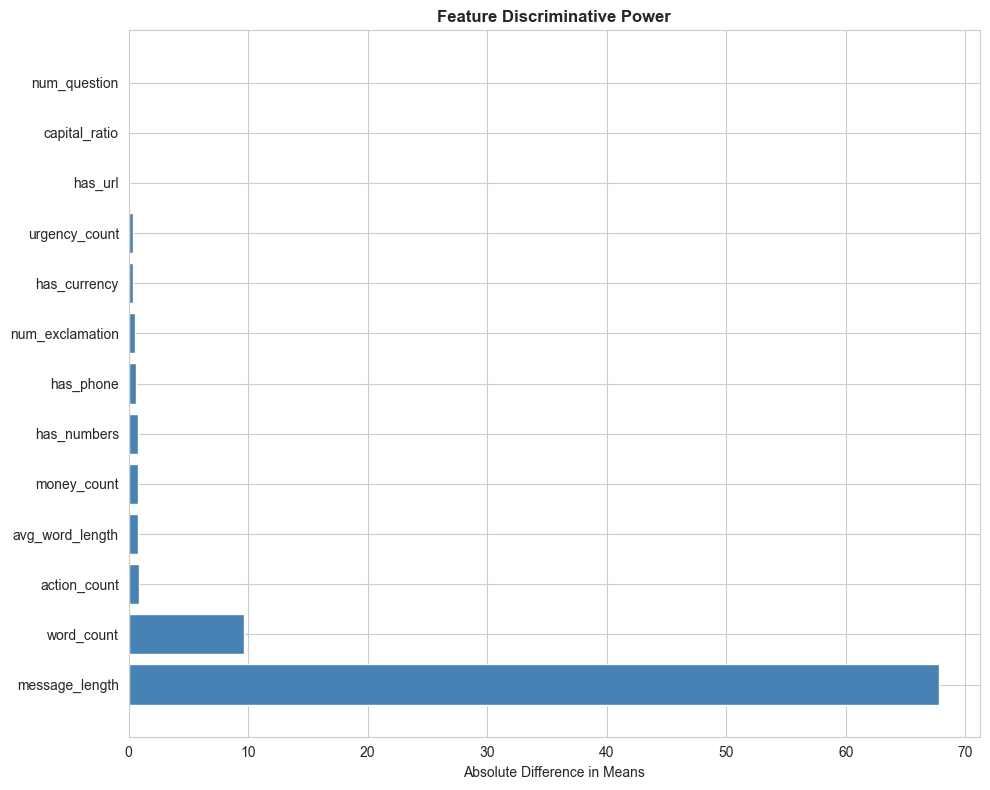

✓ Enhanced dataset saved to: data/processed/spam_with_features.csv
  Total features: 25
  New features added: 23


In [ ]:
# Feature importance summary

# Calculate mean difference between classes for each feature
feature_importance = {}

for col in feature_cols:
    ham_mean = df[df['label'] == 'ham'][col].mean()
    spam_mean = df[df['label'] == 'spam'][col].mean()
    difference = abs(spam_mean - ham_mean)
    feature_importance[col] = difference

# Sort by importance
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

print("\nFeatures ranked by class separation (larger = more discriminative):")
for feature, importance in sorted_features:
    print(f"{feature:25} : {importance:.4f}")

# Visualize
plt.figure(figsize=(10, 8))
features = [f[0] for f in sorted_features]
importances = [f[1] for f in sorted_features]

plt.barh(features, importances, color='steelblue')
plt.xlabel('Absolute Difference in Means')
plt.title('Feature Discriminative Power', fontweight='bold')
plt.tight_layout()
plt.show()


# Saving data set

# Save dataset with all new features
df.to_csv('../data/processed/spam_with_features.csv', index=False)
print("dataset with features saved to: data/processed/spam_with_features.csv")
print(f"  Total features: {df.shape[1]}")
print(f"  New features added: {df.shape[1] - 2}") 
